In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib

import pickle

import fun

matplotlib.rc('text', usetex=True)

In [4]:
L = 1620
nn_mat = fun.return_nn(L)
beta = (1.)/2.26918531421

generate_initial_conf = False

if generate_initial_conf:
    lattice = np.random.choice([-1,1], size = L**2).reshape(L,L)
    lattice = lattice.astype(np.int8)

    lattice = fun.wolff_wrapper(lattice, nn_mat, beta, Nsteps = int(1e6))
    np.save('data/IsingCritConf.npy', lattice)

else:
    lattice = np.load('data/IsingCritConf.npy')

In [5]:
b = 3

CG_lattices = [lattice.copy()]

for _ in range(4):
    CG_lattices.append(fun.block_transform(CG_lattices[-1].copy(), b))

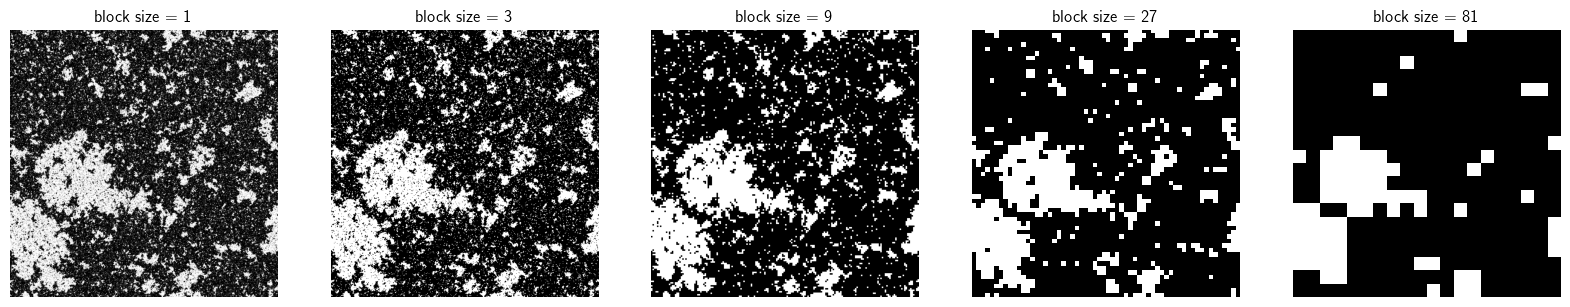

In [6]:
fig, ax = plt.subplots(1,5, figsize = (20,5))

for i in range(5):
    ax[i].imshow(CG_lattices[i], cmap = 'binary')
    ax[i].set_title(f'block size = {b**i}')
    ax[i].axis('off')

plt.show()

In [6]:
import os

data_new = []
for file in os.listdir('data/all_confs'):
    data_new.append(np.load('data/all_confs/' + file).astype(np.int8))

data_new = np.array(data_new).reshape(-1, L, L)

In [7]:
all_confs = np.concatenate((data_new, np.load('data/EquilibriumConfigurations.npy')), axis = 0).astype(np.int8)
all_confs.shape

(4532, 1620, 1620)

In [8]:
data_new = None

In [8]:
CG_all_confs = [all_confs.copy()]

for i in range(4):
    print("CG step:", i)
    current_confs = np.zeros((all_confs.shape[0], all_confs.shape[1]//b**(i+1), all_confs.shape[2]//b**(i+1)), dtype=np.int8)
    for idx, conf in enumerate(CG_all_confs[-1]):
        current_confs[idx] = fun.block_transform(conf, b)
    CG_all_confs.append(current_confs.astype(np.int8))

CG step: 0
CG step: 1
CG step: 2
CG step: 3


In [9]:
compute_spin_products = True

if compute_spin_products: 
    CG_spin_poducts = []

    for idx, data in enumerate(CG_all_confs):
        print(idx)
        CG_spin_poducts.append(fun.find_spin_products(data))

    with open('data/CG_spin_poducts.pkl', 'wb') as f:
        pickle.dump(CG_spin_poducts, f)
else:
    with open('data/CG_spin_poducts.pkl', 'rb') as f:
        CG_spin_poducts = pickle.load(f)

0
1
2
3
4


In [10]:
print('done')

done


In [11]:
CG_chi = []
CG_chi_tilde = []

for i in range(len(CG_spin_poducts) - 1):
    chi = np.cov(CG_spin_poducts[i+1].T, bias = False)
    CG_chi.append(chi)

    chi_tilde = np.zeros(chi.shape)

    for mu in range(chi.shape[0]):
        for nu in range(chi.shape[1]):
            chi_tilde[mu, nu] = fun.cov(CG_spin_poducts[i+1][:, mu], CG_spin_poducts[i][:, nu])

    CG_chi_tilde.append(chi_tilde)

In [12]:
CG_T_mat = []

for chi, chi_tilde in zip(CG_chi, CG_chi_tilde):
    CG_T_mat.append(np.linalg.inv(chi) @ chi_tilde)

CG_T_mat = np.array(CG_T_mat)

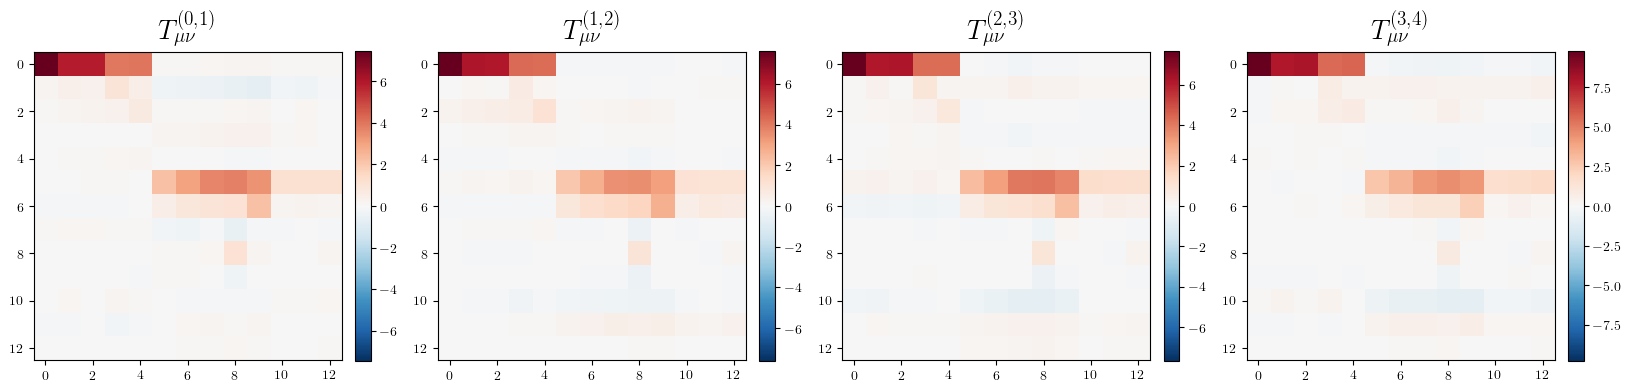

In [13]:
fig, ax = plt.subplots(1, CG_T_mat.shape[0], figsize = (20,5))

vmin = np.min(CG_T_mat)
vmax = np.max(CG_T_mat)

for i in range(CG_T_mat.shape[0]):
    #center the cmap in zero

    im = ax[i].imshow(CG_T_mat[i], cmap = 'RdBu_r', norm = matplotlib.colors.CenteredNorm())
    ax[i].set_title(r'$T_{\mu \nu}^{(' + str(i) + ', ' + str(i+1) +')}$', pad = 10, fontsize = 20)
    plt.colorbar(im, ax = ax[i], fraction = 0.046, pad = 0.04)

plt.show()

In [14]:
CG_EigEven, CG_EigOdd = fun.get_even_odd_eigvals(CG_T_mat)

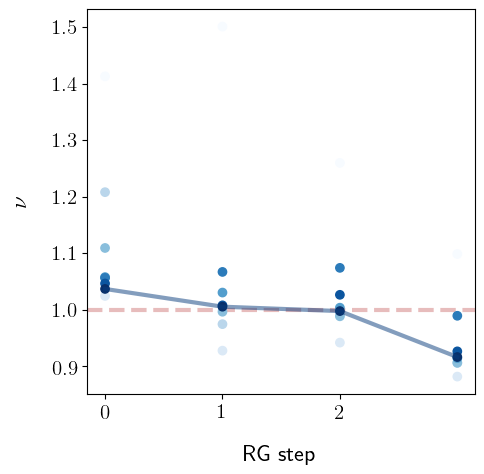

In [15]:
fig, ax = plt.subplots(figsize = (5,5))
c = 0
for ye_list in CG_EigEven:
    ax.scatter([c]*len(ye_list), [np.log(b)/np.log(np.real(val)) for val in ye_list],
                c = np.arange(len(ye_list)), cmap = plt.get_cmap('Blues'))
    c += 1
ax.plot(np.arange(len(CG_EigEven)), [np.log(b)/np.log(np.real(val)[-1]) for val in CG_EigEven], alpha = 0.5,
         lw = 3, color = plt.get_cmap('Blues')(0.95))
#ax.set_ylim(0.9, 1.3)
ax.set_xlabel('RG step', fontsize = 17, labelpad = 15)
ax.set_xticks([0,1,2])
ax.set_ylabel(r'$\nu$', fontsize = 17, labelpad = 15)
ax.tick_params(labelsize=15)
plt.axhline(1, ls = '--', lw = 3, color = 'firebrick', zorder = -1, alpha = 0.3)


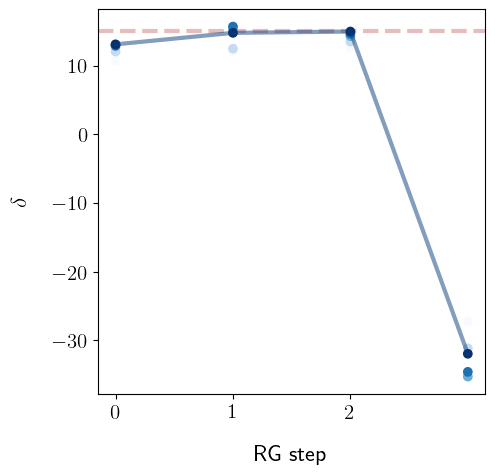

In [16]:
fig, ax = plt.subplots(figsize = (5,5))
c = 0
for ye_list in CG_EigOdd:
    ax.scatter([c]*len(ye_list), [np.log(np.real(val))/np.log(b)/(2-np.log(np.real(val))/np.log(b)) for val in ye_list],
                c = np.arange(len(ye_list)), cmap = plt.get_cmap('Blues'))
    c += 1
ax.plot(np.arange(len(CG_EigOdd)), [np.log(np.real(val[-1]))/np.log(b)/(2-np.log(np.real(val[-1]))/np.log(b)) for val in CG_EigOdd], alpha = 0.5,
         lw = 3, color = plt.get_cmap('Blues')(0.95))
#ax.set_ylim(0.9, 1.3)
ax.set_xlabel('RG step', fontsize = 17, labelpad = 15)
ax.set_xticks([0,1,2])
ax.set_ylabel(r'$\delta$', fontsize = 17, labelpad = 15)
ax.tick_params(labelsize=15)
plt.axhline(15, ls = '--', lw = 3, color = 'firebrick', zorder = -1, alpha = 0.3)


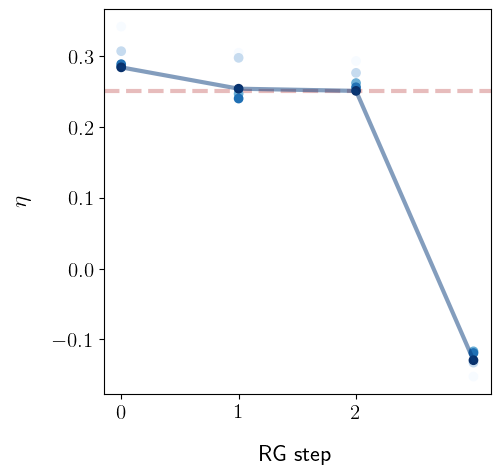

In [17]:
fig, ax = plt.subplots(figsize = (5,5))
c = 0
for ye_list in CG_EigOdd:
    ax.scatter([c]*len(ye_list), [4 - 2*np.log(np.real(val))/np.log(b) for val in ye_list],
                c = np.arange(len(ye_list)), cmap = plt.get_cmap('Blues'))
    c += 1
ax.plot(np.arange(len(CG_EigOdd)), [4 - 2*np.log(np.real(val[-1]))/np.log(b) for val in CG_EigOdd], alpha = 0.5,
         lw = 3, color = plt.get_cmap('Blues')(0.95))
#ax.set_ylim(0.9, 1.3)
ax.set_xlabel('RG step', fontsize = 17, labelpad = 15)
ax.set_xticks([0,1,2])
ax.set_ylabel(r'$\eta$', fontsize = 17, labelpad = 15)
ax.tick_params(labelsize=15)
plt.axhline(0.25, ls = '--', lw = 3, color = 'firebrick', zorder = -1, alpha = 0.3)
